#  Behavior Detection

## Introduction

Computer environments such as those based on educational games, interactive simulations, and educational platforms are providing more and more data, which can enable a personalized adaptation of the environment itself. For instance, this data can be used to train models able to detect the extent to which students are using the educational platform properly and react accordingly. Empowering platforms with these models can serve as a means for adaptive interventions that are of paramount importance to ensure no student is left behind.      

The goal of this homework is to build a **behavior detector**, namely a classifier. Specifically, you are asked to build a detector able to classify the extent to which the students are off-task, i.e., whether students are performing interactions that are not related to the classroom's objectives. To this end, we will use a public data set which is stored in <code>ca1‐dataset.csv</code> in a CSV format. The dataset includes features at the grain size of all the actions that occurred during 20-second field observations for a student (so one student can occur in more than one record of the dataset). An example feature associated with one record of the dataset is the number of wrong actions made by the corresponding student in the last 20 seconds (more details on the features will be provided later). In addition to features, each record includes the "OffTask" label (Y or N), which is the target we ask you to predict, based on the values of the features. 

Specifically,  we will ask you to:
1. **Part 1:** Explore the dataset and select up to **5** features from those in the CSV file that you think are the most predictive of the off-task label.
2. **Part 2:** Design, fit, and interpret a Regression model for off-task prediction, based on the features you selected. 
3. **Part 3:** Design, fit, and interpret a Decision Tree classifier for off-task prediction, based on the features you selected, and investigate the impact of one hyper-parameter on the final results you obtain. 
3. **Part 4:** Design, fit, and interpret a Random Forest classifier for off-task prediction, based on the features you selected, investigate the impact of one hyper-parameter on the final results you obtain, and compare your findings with those you obtained with a single decision tree.
4. **Part 5:** Conduct feature engineering to improve the features in the original data set, using the data in a second more fine-grained dataset we will provide to you. Specifically, you will be asked to create at least **5** new features that cannot be created using just the original data set, add the new features to the original data set, and see what impact they have on the Random Forest classifier. 





## About the data

Our target is to identify that one specific behavior for students. A detailed description of features is given below. The features are related to the information on how the students interact with the system for individual actions. 

The description of the features for the individual raw actions in <code>ca1‐dataset.csv</code> is provided below. 


In the description, each line in the raw data set is associated with some interaction widget in the educational software which are denoted by "Cell". In addition, "Production" is the skill that the students are expected to learn. 

| Name                   | Description                         |
| ---------------------- | ------------------------------------------------------------ |
|   Avgright| Average of true feature (1 if the action is right, 0 otherwise) during observations|
|	Avgbug| Average of the bug feature (1 if there is a bug, 0 otherwise) during observations|
|	Avgpchange| Average number of changes of knowledege estimate during observations|
|	Avgtime| Average number of time spent during observations|
|	AvgtimeSDnormed| Average the (time taken – avg(cell) / SD(cell) for the last action of observations (SD is a function)|
|	Avgtimelast3SDnormed| Average of the (time taken – avg(cell) / SD(cell) for the last 3 action of observations (SD is a function)|
|	Avgtimelast5SDnormed| Average of the (time taken – avg(cell) / SD(cell) for the last 5 action of observations (SD is a function)|
|	Avgnotright| Average number of not right actions during observations|
|	Avghowmanywrong-up| Average number of total number of actions where this production was wrong|
|	Avgwrongpct-up| Average number of (total number of actions where this production was wrong, not just first attempt)/( number of steps where skill encountered so far (inclusive of current))|
|	Avgtimeperact-up| Average of timeperact-up feature (Total time so far on all actions involving this production, for all problems)|
|	AvgPrev3Count-up| Average count of involving in the same interface widget for the last 3 actions, during observations|
|	AvgPrev5Count-up| Average count of involving in the same interface widget for the last 5 actions, during observations|
|	Avgrecent5wrong| Average number of wrong actions in the last 5 actions|
|	Avgmanywrong-up| Average of the total number of wrong actions up to the current action|
|	Unique-id| ID of the aggregated observation (one observation aggregates interactions within a 20 second timeframe)|
|	namea| ID of the student|
|	OffTask| Classification target |

**The data set is available in the folder data**. 


In [1]:
#### PACKAGE IMPORTS ####

# Your libraries here
# Run this cell first to import all required packages. Do not make any imports elsewhere in the notebook

# YOUR CODE HERE
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import RobustScaler, MinMaxScaler
import statsmodels.api as sm
from sklearn import tree
from sklearn.ensemble import RandomForestClassifier

%matplotlib inline

## **0 Load the data set**
---

In [2]:
df = pd.read_csv("./data/ca1-dataset.csv")

# Let's see how the dataframe looks like
print("length of the dataframe:", len(df))
print("first rows of the dataframe:\n")
df.head()

length of the dataframe: 763
first rows of the dataframe:



Unique-id       namea OffTask  \
0  awagner-closeloop-ins_h1zaz4-03.30.2011_at_13:...  stuZgy46jl       N   
1  awagner-closeloop-ins_h1zaz4-03.30.2011_at_13:...  stuZ77be0l       N   
2  awagner-closeloop-ins_h1zaz4-03.30.2011_at_13:...  stuZ5lp7k7       N   
3  awagner-closeloop-ins_h1zaz4-03.30.2011_at_13:...  stuZ9idg5l       N   
4  awagner-closeloop-ins_h1zaz4-03.30.2011_at_13:...  stuZ4lil98       N   

   Avgright  Avgbug  Avgpchange    Avgtime  AvgtimeSDnormed  \
0  1.000000     0.0         0.0  12.000000         0.446098   
1  1.000000     0.0         0.0   7.500000        -0.260956   
2  1.000000     0.0         0.0  25.333333         0.301574   
3  0.833333     0.0         0.0   3.500000        -0.554844   
4  1.000000     0.0         0.0   5.250000        -0.525770   

   Avgtimelast3SDnormed  Avgtimelast5SDnormed  Avgnotright  \
0              0.288201              0.454262     0.000000   
1             -0.774506              0.000000     0.000000   
2             -1.529301             -0.508076     0.000000   
3             -1.366454             -2.018076     0.166667   
4             -1.829775             -2.621184     0.000000   

   Avghowmanywrong-up  Avgwrongpct-up  Avgtimeperact-up  AvgPrev3Count-up  \
0            0.000000        0.000000         12.000000               0.0   
1            0.000000        0.000000          8.750000               0.0   
2            0.000000        0.000000         26.083333               0.0   
3            0.166667        0.166667          4.902778               0.0   
4            0.000000        0.000000          5.875000               0.0   

   AvgPrev5Count-up  Avg recent5wrong  Avgmanywrong-up  
0               0.0               1.0              0.0  
1               0.0               0.0              0.0  
2               0.0               1.0              0.0  
3               0.0               0.0              0.0  
4               0.0               0.0              0.0

<a id="section1"></a>
## 1 Preprocess the data
----

In this section, your goal is to understand the data and select 5 meaningful features that will be used in the later sections to predict the off-task behavior.   

Specifically, you should:

1. Select 5 features from the original dataset that are meaningful for the off-task prediciton task.  
2. Justify your decision: How did you select the five features? Add visualizations (from your Exploratory Data Analysis) to support your answer. 
3. Create a function that splits the data set into X (the five features you selected) and y (target variable) and gives appropriate format to the target variable. 
4. Justify your decision: Which proportion of the data set will be used to validate the models. Why? 
5. Finally, do any other necessary preprocessing steps.
6. Justify the changes done to the data 

<a id="section1.1"></a>
### 1.1 

List 5 features from the original dataset that are meaningful for the off-task prediciton task.  

<font color='green'>For this subtask, several solutions are possible. However, what is more important, is that the choice of the 5 features are resonably justified in the next subtask.</font> 

In [3]:
#### GRADED CELL ####
### 1.1

# YOUR CODE HERE
meaningful_features = ["Avgright", "Avgtimelast3SDnormed", "Avgwrongpct-up", "Avgbug", "Avg recent5wrong"] # list of column names

In [4]:
df_five = df[meaningful_features + ['OffTask']]
df_five_id = df[['Unique-id']]
df_five.head()

Avgright  Avgtimelast3SDnormed  Avgwrongpct-up  Avgbug  Avg recent5wrong  \
0  1.000000              0.288201        0.000000     0.0               1.0   
1  1.000000             -0.774506        0.000000     0.0               0.0   
2  1.000000             -1.529301        0.000000     0.0               1.0   
3  0.833333             -1.366454        0.166667     0.0               0.0   
4  1.000000             -1.829775        0.000000     0.0               0.0   

  OffTask  
0       N  
1       N  
2       N  
3       N  
4       N

### 1.2
Justify your decisions. How did you select the five features? Add visualizations to support your answer. 

<font color='green'> As emphasized in the the desciption of this subtask, it is essential that the choice of the 5 features is reasonably <b>justified</b> and <b>supported by visualizations.</b></font> 

<font color='green'> To approach this task, you could do a supervised or an unsupervised feature selection. Supervised methods will take into account the relation of the features with the target variable (in our case OffTask). For this purpose, you could try to look at features that show some correlations with the target variable. In the following, we will however, illustrate an unsupervised approach, in which we will not specifically look at the relationships of the potential features with the target variable. A good way to start, would be to do some exploratory data analysis, to get a feeling about the data set at hand. As shown in previous tutorials, one useful way to visualize data is to use histograms. Below we show examples of histograms that visualize the distribution of the different features by their binary OffTask values ("Y" or "N"). From the histograms it can be seen that the data set is highly unbalanced, with a much larger proportion of data labeled with "N" for the OffTask variable. Noticing this is crucial so that the results from the subsequent parts of this homework can be interpreted appropriately. Moreover, the histograms allow us to analyze which features might be informative for the classification task. For instance, a feature like `Avgmanywrong-up` may not be a good choice, since the distributions for both labels are similar and moreover, concentrated around the same values. It should be however, acknowledged that for this particular data set it can be also challenging to observe clear differences in the distributions for the other features. </font> 

<font color='green'> To complement the histograms, another useful analysis could be to look at the correlations between the features. The second figure displays a correlation heat map as introduced in the last homework (HW1). This graph allows us to see whether some features are strongly correlated among them. For instance, `Avgtimelast3SDnormed` and `Avgtimelast5SDnormed` are strongly correlated (0.9), as well as `Avgright` and `Avgnotright` (-1.0). These pairs therefore seem to contain redudant information and it would not make sense to select them together. As a matter of fact, the latter pair are actually the exact opposites, which explains the perfect negative correlation.</font> 

<font color='green'> Based on the above presented considerations, one reasonable selection of features would be e.g. `Avgright, Avgtimelast3SDnormed, Avgwrongpct-up, Avgbug, Avg recent5wrong`.</font> 


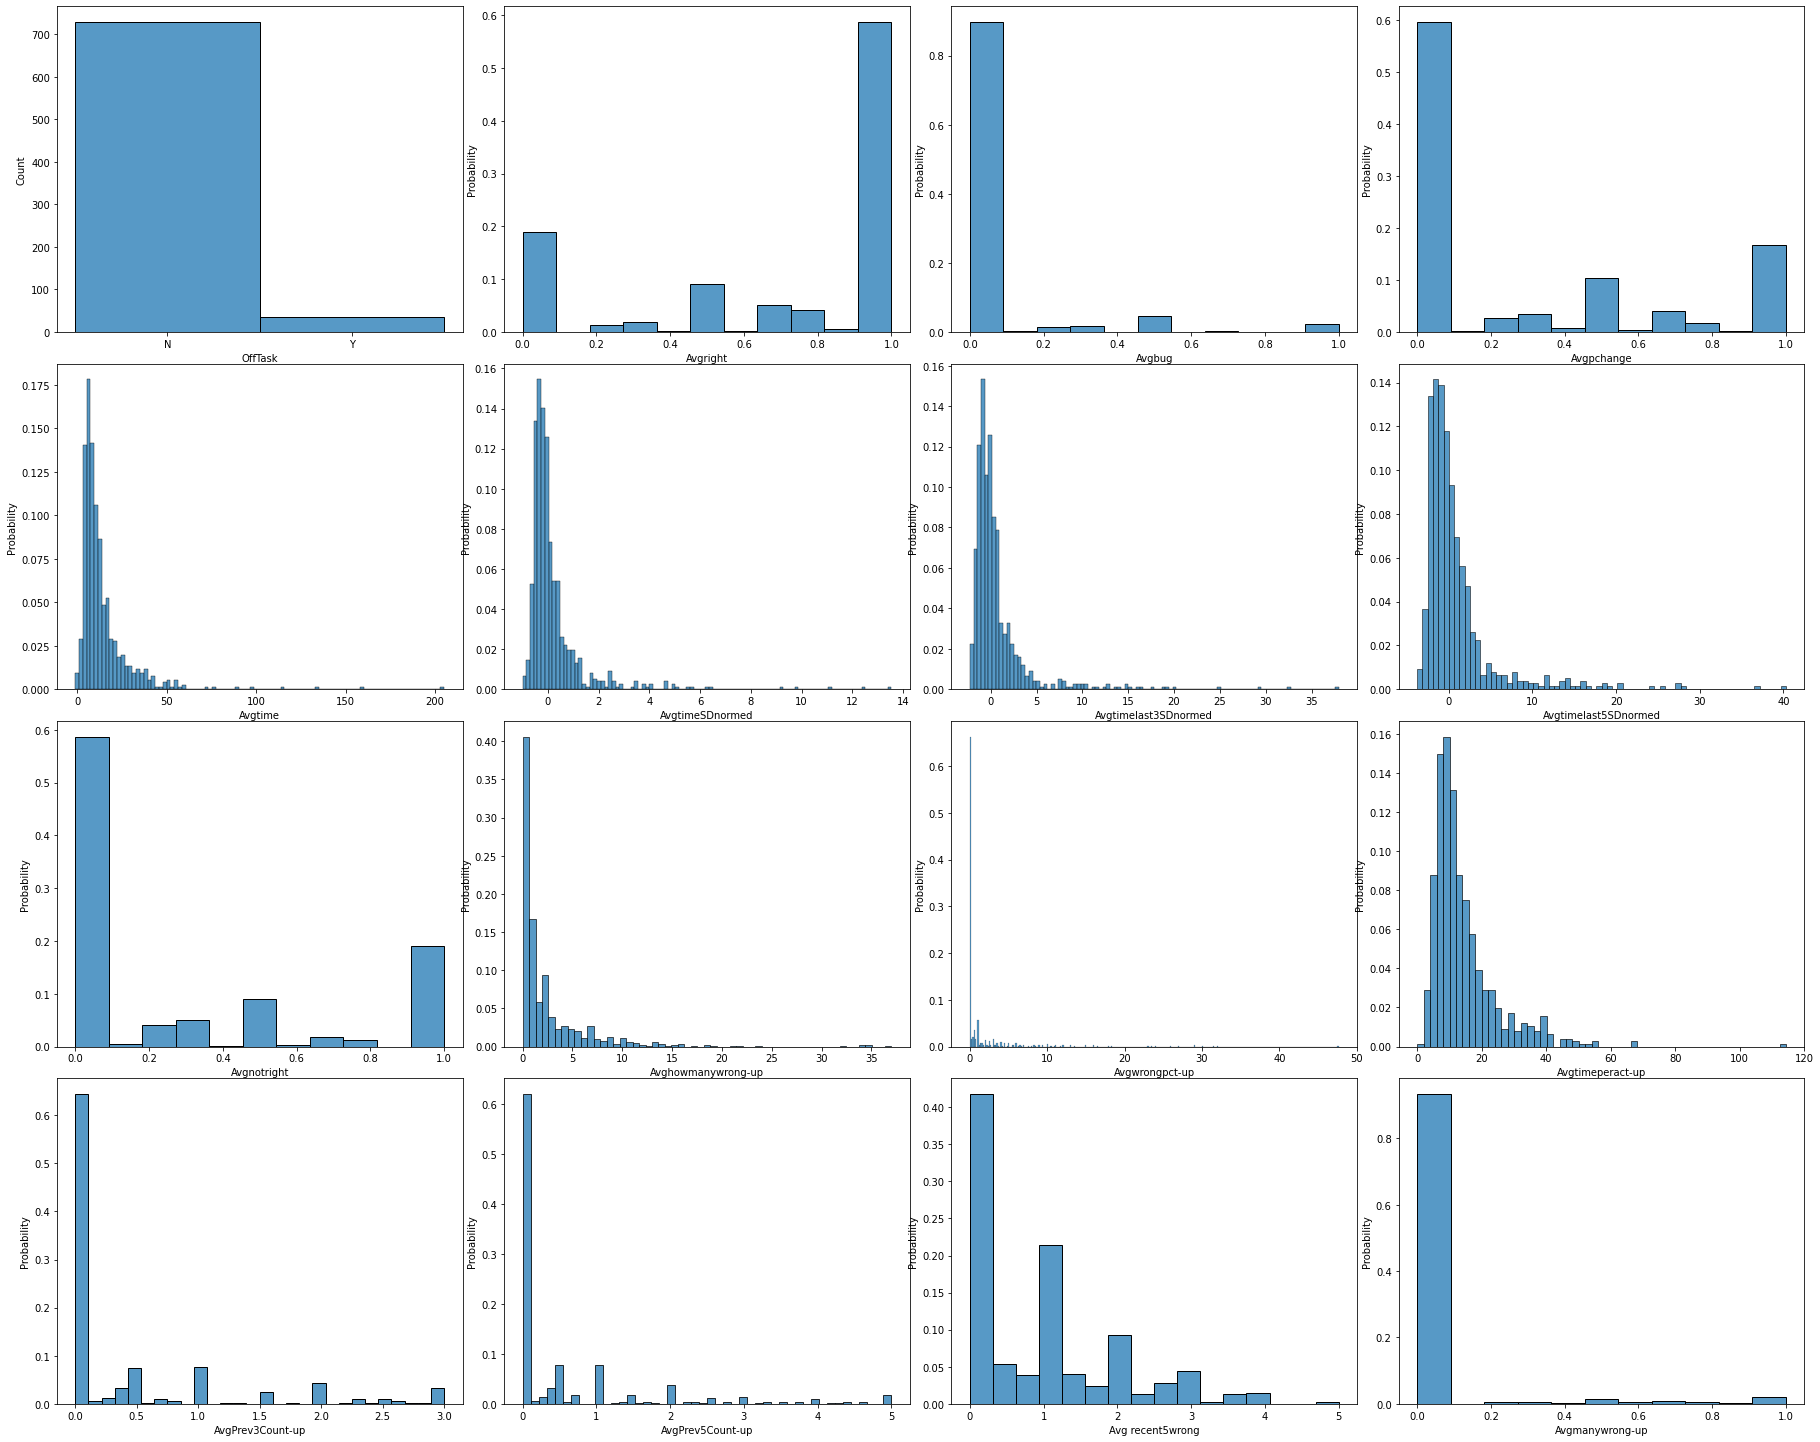

In [5]:
# visualize the distribution of features
df_features = df.drop(columns=['Unique-id', 'namea']) # drop non-features

fig, ax = plt.subplots(4,4, figsize=(25,20)) # create subplots
fig.tight_layout() # adjust plotting layout
for i, column_name in enumerate(df_features.columns):
    if column_name == "OffTask":
        sns.histplot(data=df_features, x=column_name, ax=ax[i//4,i%4]) # visualize counts for both OffTask levels
    else:
        sns.histplot(data=df_features, x=column_name, ax=ax[i//4,i%4], stat="probability") # visualize distribution of each feature seperated by OffTask level


<AxesSubplot:title={'center':'Correlation Heat Map'}>

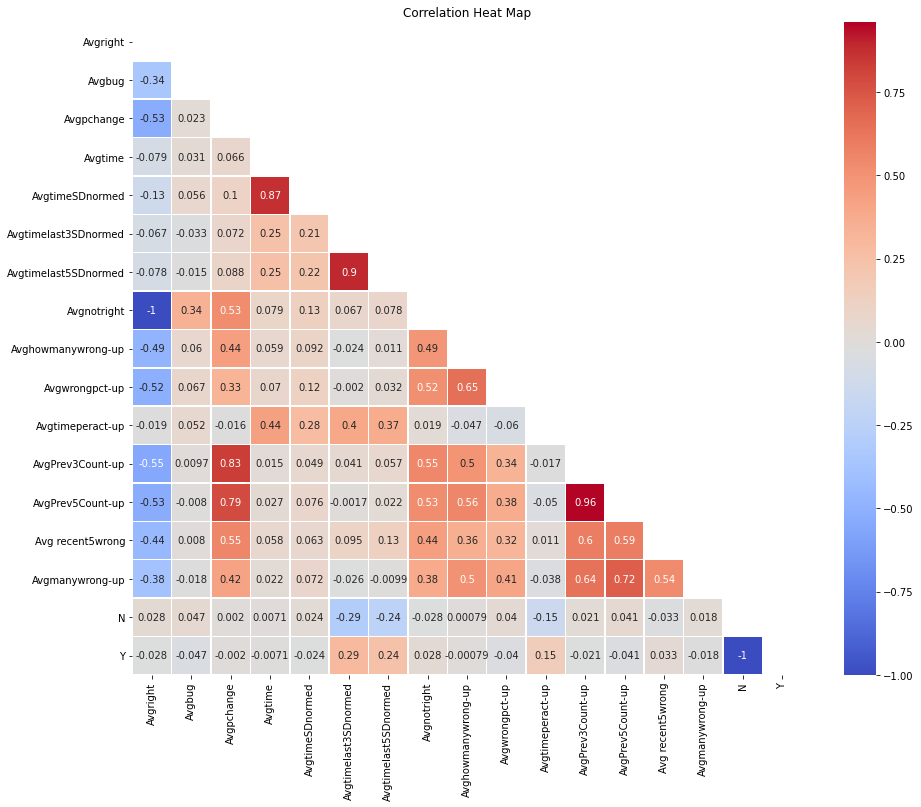

In [6]:
# visualize the correlation between features (including target)

df_visualize = pd.concat([df, pd.get_dummies(df['OffTask'])], axis=1) # change OffTask label into indicator variables

fig, ax = plt.subplots(figsize=(15,12)) # create sublots
plt.title("Correlation Heat Map") # set the fig title
mask = np.triu(df_visualize.corr()) # create upper triangle of an array

sns.heatmap(df_visualize.corr(), annot = True, ax=ax, mask=mask, cmap= 'coolwarm', linewidths=.5) # visualize

### 1.3

Create a function that splits the data set into training and validation set. The target variable (y) is off-task.

<font color='green'> This is a pure implementation task, that basically asks for the correct use of scikit-learn's train_test_split() function. </font> 

In [7]:
#### GRADED CELL ####
### 1.3
def split_data(df):
    """
    Splits data into X_train, X_val, y_train, y_val. 
    
    20% of the data should be randomly assigned to the validation set. 
    
    Parameters
    ----------
    df : DataFrame with the five selected features 
    
    Returns:
    -------
    X_train: DataFrame with features (training set) 
    X_val: DataFrame with features (validation set)
    y_train: np.array with target variable (training set) (Should take values 0,1)
    y_val: np.array with target variable (validation set) (Should take values 0,1)
                
    """
    # YOUR CODE HERE
    X = df.drop('OffTask', axis=1) # drop target
    y = (df.OffTask == 'Y').astype(int) # convert into 0 and 1
    X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=0) # split train and validation data set

    return X_train, X_val, y_train, y_val

In [8]:
X_train, X_val, y_train, y_val = split_data(df_five)

### 1.4 - 1.6

<font color='green'> These subtasks were mentioned in the initial task decription, but did not have specific exercise cells in the notebooks. Therefore, no points were deducted if the questions were not addressed. </font> 

<font color='green'> <b>Splitting the data into train and test sets:</b> A common approach is to split into 80% training data and 20% test data. If you are interested in knowing why these numbers were chosen, check out the [Pareto principle](https://en.wikipedia.org/wiki/Pareto_principle). However, depending on your data set, also other splits are possible, e.g. scikit-learn's train_test_split function uses by default a 75/25 split, also 70/30 splits are used quite often.</font> 

<font color='green'> <b>Other preprocessing steps:</b> As presented in the previous homework and tutorials, before using the data to train your models, it is advisable to analyze whether some data cleaning is necessary. We will not go into the details here, especially, because for this data set no major data cleaning is needed. However, one preprocessing step we may consider, is to perform a rescaling of the features. From the histograms we can observe that the features have very different ranges of values. Therefore, features with larger ranges may have stronger influences on our models. We can also see that the features do not follow gaussian distributions and often have some outliers. We therefore, decide to scale the data using scikit-learn's RobustScaler(). We learn the scaler from the training data, and then apply it to both the training and test data, following the idea that the test data should always represent some "unseen" data. Anything that is learned (including the scaler), should be learned from the training data. </font> 

In [9]:
cols = X_train.columns
scaler = RobustScaler().fit(X_train)
X_train = pd.DataFrame(scaler.transform(X_train), columns=cols)
X_val = pd.DataFrame(scaler.transform(X_val), columns=cols)

<a id="section2"></a>
## 2 Regression model
---

As seen in class, different link functions can be used in Generalized Linear Models.

Select the appropriate link function to understand the relationship between OffTask (target label) and the previously selected features. 

In this exercise, you should:
1. Create a regression model to explain the variable `OffTask` using the previously selected features.  
2. Calculate accuracy of the model's predictions using the validation set. 
3. Interpret and explain the coeficients. Which features are significant? Did the model successfully describe the data? How do you know?  
4. What changes could you do to improve the accuracy of the model (with the same type of regression model)?
5. Implement your suggestions and re-run the model.
6. Do you observe any change in the accuracy? Discuss your results

### 2.1
Create a generalized linear regression model to explain the variable `OffTask`

<font color='green'> This is a pure implementation task, that basically asks for the correct use of statmodels' GLM() function. Note that it is important to specify the appropriate distribution family (sm.families.Binomial) as well as the seed for the random_state (can be any integer). The latter is important for you to always get the same results when rerunning the simulation. </font> 

In [10]:
#### GRADED CELL ####
### 2.1
def build_regression(X_train, y_train):
    """
    Splits data into X and y

    Parameters
    ----------
    X_train: DataFrame with features (training set) 
    y_train: np.array with target variable (training set) 

    Returns:
    -------
    summary: detailed regression output
             including coefficients and p-values associated
    """
    # YOUR CODE HERE
    clf = sm.GLM(y_train, X_train.values, family=sm.families.Binomial(), random_state=0).fit() # create a GLM model and train
    summary = clf.summary() # get summary
    
    return clf, summary

In [11]:
reg, summary = build_regression(X_train, y_train)
summary

<class 'statsmodels.iolib.summary.Summary'>
"""
                 Generalized Linear Model Regression Results                  
==============================================================================
Dep. Variable:                OffTask   No. Observations:                  610
Model:                            GLM   Df Residuals:                      605
Model Family:                Binomial   Df Model:                            4
Link Function:                  logit   Scale:                          1.0000
Method:                          IRLS   Log-Likelihood:                -303.79
Date:                Wed, 24 Mar 2021   Deviance:                       607.58
Time:                        08:53:12   Pearson chi2:                 1.21e+03
No. Iterations:                     8                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
x1             1.6955      0.296      5.729      0.000       1.115       2.276
x2            -0.0538      0.057     -0.943      0.346      -0.166       0.058
x3            -0.2001      0.137     -1.462      0.144      -0.468       0.068
x4            -5.0193      2.570     -1.953      0.051     -10.057       0.019
x5             0.5696      0.186      3.056      0.002       0.204       0.935
==============================================================================
"""

### 2.2 

Calculate the accuracy. Given the classifier `clf`, features `X_val` and labels `y_val`, calculate the prediction accuracy. 

<font color='green'> Also this is a pure implementation task, that basically asks for the correct use of scikit-learns predict() function and the correct calculation of the prediction accuracy. </font> 

In [12]:
#### GRADED CELL ####
### 2.2
def calculate_accuracy(clf, X_val, y_val):
    """
    Calculates accuracy (percentage of validation samples 
    that are correctly classified) for linear regression

    Parameters
    ----------
    clr: previously trained classifier
    X_val: DataFrame with features (validation set)
    y_val: np.array with target variable (validation set)
    
    Returns:
    -------
    accuracy: float 
                
    """
    # YOUR CODE HERE
    y_pred = clf.predict(X_val) # predict on validation data set
    accuracy = sum((y_pred > 0.5).to_numpy() == y_val.to_numpy())/len(y_val) # calculate accuracy
    
    return accuracy

In [13]:
"validation score of regression:", calculate_accuracy(reg, X_val, y_val)

('validation score of regression:', 0.6928104575163399)

### 2.3
Interpret and explain the coeficients. Which features are significant? Did the model successfully describe the data? How do you know? 

<font color='green'><b> Interpret and explain the coeficients. </b></font> 

<font color='green'> This question can be answered by looking at the `coef` column of the model summary. The coefficients describe describes the relationship between the preidctors (the five features) and the response variable (i.e. the target `OffTask`). Higher values indicate a stronger influence of the input variable on the output variable in the trained model. In our example we can, for instance, observe that x4 (`Avgbug`) has a large (negative) coefficient (-5.02). </font> 

<font color='green'><b> Which features are significant? </b></font> 

<font color='green'> Indeed, it is not enough to only look at the model coefficients of each model, to determine whether a feature is significant in predicting the dependent variable. To decide whether a feature is significant, you should analyze the p-values in the `P>|z|` column of the summary table. Depending on the siginificance level you choose (a common choice is e.g. alpha = 0.05), you can then decide which features are predicitive. The p-value for each term tests the null hypothesis that the coefficient is equal to zero (no effect). A p-value below the significance level indicates that you can reject the null hypothesis. In other words, a predictor that has a low p-value is likely to be a meaningful addition to your model because changes in the predictor's value are related to changes in the response variable. Conversely, a larger (insignificant) p-value suggests that changes in the predictor are not associated with changes in the response. In the present example, this is only the case for x1 (`Avgright`) and x5 (`Avg recent5wrong`). With p = 0.051, x4 (`Avgbug`) is close to be statistically significant. We can then decide whether it is still a feature we want to consider as predictive for our model. </font>

<font color='green'><b> Did the model successfully describe the data? How do you know? </b></font> 

<font color='green'> To answer this question, it is not enough to report high accuracy values achieved with the model. One should also look at potential baseline models, against which the performance of the model can be tested. Two very simple choices could be a random classifier distinguishing between the two levels of `OffTask` with an accuracy of 0.5, as well as a majority class classifier. Since the data set is very unbalanced, the latter would already yield an accuracy of 146/153 = 0.954 for the test data set, as shown below. Furthermore, to evaluate the model's performance in more detail and understand whether a specific class is predicted better or worse, we could also look at the proportions of true/false positives/negatives, as shown below. </font> 

In [14]:
# ratio of majority category of samples in the validation dataset
print("ratio of majority category of samples:", sum(1-y_val)/len(y_val))

# calculate true positive, false positive, true negative, false positive
y_pred = reg.predict(X_val)
true_positive = sum(np.logical_and((y_pred > 0.5).to_numpy(), y_val.to_numpy()))/sum(y_val.to_numpy())
true_negative = sum(np.logical_and((y_pred < 0.5).to_numpy(), (1-y_val.to_numpy())))/sum((1-y_val.to_numpy()))
false_positive = sum(np.logical_and((y_pred > 0.5).to_numpy(), (1-y_val.to_numpy())))/sum((1-y_val.to_numpy()))
false_negative = sum(np.logical_and((y_pred < 0.5).to_numpy(), y_val.to_numpy()))/sum(y_val.to_numpy())

print("true_positive:", true_positive)
print("true_negative:", true_negative)
print("false_positive:", false_positive)
print("false_negative:", false_negative)



ratio of majority category of samples: 0.954248366013072
true_positive: 0.14285714285714285
true_negative: 0.7191780821917808
false_positive: 0.2808219178082192
false_negative: 0.8571428571428571


### 2.4
What changes could you do to improve the accuracy of the model (with the same type of regression model)?
Explain and justify your decisions.

<font color='green'> For this subtask, multiple solutions are possible. One very straight forward approach would be to extend the feature set with more features. For this purpose, we could for instance select other features from our initial set. However, in the following we introduce another approach, called [data augmentation](https://en.wikipedia.org/wiki/Data_augmentation). Following this approach could help us in better training our regression model. Another approach could be to experiment with different ways of scaling the features (not implemented here). </font> 

<font color='green'> Another, more sophisticated, but also computationally heavier approach is [Best Subset Selection](https://quantifyinghealth.com/best-subset-selection/) (not implemented here). In this approach, you run the model multiple times with different numbers and combinations of predictors. Based on a predefined quality metric (e.g. predicition error, BIC, AIC), you can then decide which is the "best" subset of features to use with the model. However, this approach can be computationally heavy, especially when you have a large number of features, and it could also result in overfitting. </font> 

### 2.5 

Implement your suggestions and re-run the model. 

In [15]:
# Data augmentation

X_train_square = pd.concat([X_train, X_train**2], axis=1) # append with square
X_val_square = pd.concat([X_val, X_val**2], axis=1) # append with square

reg, summary = build_regression(X_train_square, y_train) # build regression model

print("validation score of regression:", calculate_accuracy(reg, X_val_square, y_val))

validation score of regression: 0.8104575163398693


### 2.6
Do you observe any change in the accuracy? Discuss your results

<font color='green'> With only adding more features through data augmentation, the accuracy improved from 0.69 to 0.81. However, this result should be interpreted with the possibility that the model could now overfit to the data set. </font> 

<a id="section3"></a>
## 3 Decision Tree
---

As mentioned during the lecture, decision trees are a classification model with a tree-like structure. In the following questions, you should:

1. Train a decision tree with the original 5 features selected in question 1.1. Return the names of the three most important features.  
2. Interpret the decision tree and feature importances based on the provided visualization.  
3. Play with the maximum depth hyper-parameter. 
4. Interpret your results. 



### 3.1
Train a decision tree with the original 5 features selected in question 1.1. Return the names of the three most important features.  

<font color='green'> This is again a pure implementation task, that requires the correct use of scikit-learn's DecisionTreeClassifier and the feature_importances_ function. </font> 

In [16]:
#### GRADED CELL ####
### 3.1
def build_decision_tree(X_train, y_train, max_depth=3):
    """
    Train a decision tree classifier.
    1. Create a decision tree classifier given max_depth
    2. Train the classifier
    3. Get the importance of features
    
    Parameters
    ----------
    X_train: DataFrame with the 5 selected features (training set) 
    y_train: np.array with target variable (training set)
    max_depth : maximum depth of the decision tree
 
    
    Returns:
    -------
    clf: decision tree classifier
    feature_importance: list of the names of the 3 most important of features
                        ordered by feature importance

    """
    # YOUR CODE HERE
    clf = tree.DecisionTreeClassifier(max_depth=max_depth, random_state=0).fit(X_train, y_train) # create a Decision Tree and train
    
    feature_importance = pd.Series(clf.feature_importances_, index=X_train.columns)
    feature_importance = list(feature_importance.sort_values(ascending=False).iloc[0:3].index)
    
    return clf, feature_importance

In [17]:
 clf, feature_importance = build_decision_tree(X_train, y_train) # train the model using training data

In [18]:
print("validation score of decision tree:", clf.score(X_val, y_val))
print("most important features:", feature_importance)

validation score of decision tree: 0.954248366013072
most important features: ['Avgtimelast3SDnormed', 'Avg recent5wrong', 'Avgright']


Now we can visualize the decision tree

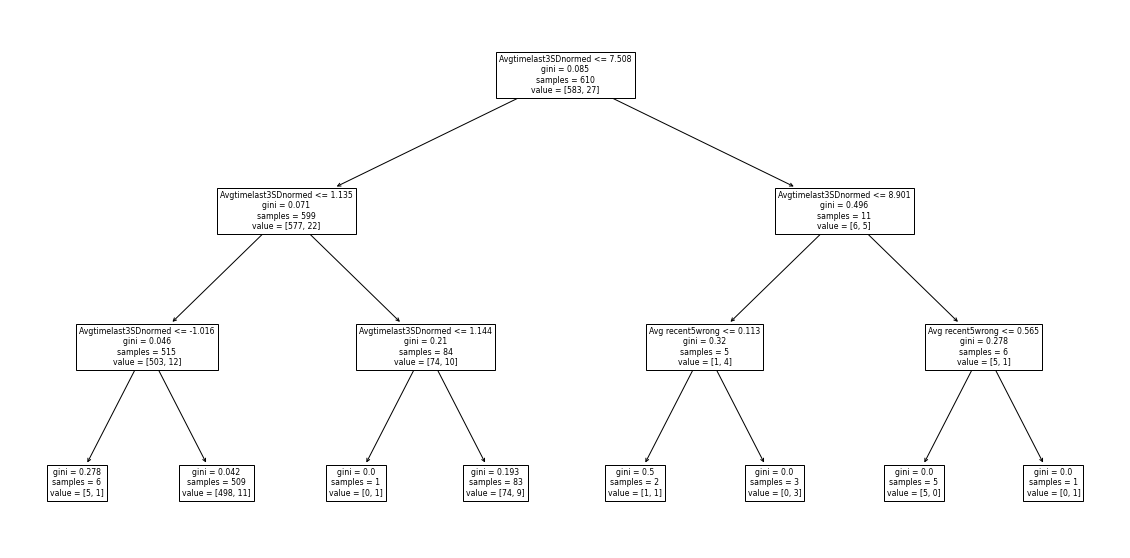

In [19]:
plt.figure(figsize=(20,10))
tree.plot_tree(clf, feature_names = X_train.columns);

### 3.2 

Interpret the decision tree and feature importances based on the provided visualization. 


<font color='green'> From the feature_importance array, as well as the plot it can be seen that using the decision tree, there are only two features that are predictive of the response variable OffTask. These features are the ones that have non-zero importance in the array. They are feature x[1] and feature x[4] (Avgtimelast3SDnormed and Avg recent5wrong). The plot visualizes that they are the only features used in the decision tree for classification.  </font> 



### 3.3 

Play with the maximum depth hyper-parameter. 

You might have noticed that there is an max_depth hyper-parameter in the Decision Tree classifier. 
Which max_depth parameter leads to the highest validation score?

Plot the accuracy with the varying depths (choose an appropriate range). 

<font color='green'> This is again a pure implementation task, in which you need to calculate and plot the accuracy for varying values of the max_depth hyper-parameter. </font> 

In [20]:
#### GRADED CELL ####
### 3.3
def explore_max_depth(X_train, X_val, y_train, y_val):
    """
    Explore the max depth parameter
    1. Get the accuracy score of the decision tree classifier at different depths
    2. Plot the accuracy at different depths
    
    Parameters
    ----------
    X_train: DataFrame with features (training set) 
    X_val: DataFrame with features (validation set)
    y_train: np.array with target variable (training set) 
    y_val: np.array with target variable (validation set)
    
    
    Returns:
    -------
    None

    """
    
    # YOUR CODE HERE
    result_train = []
    result_test = []
    for i in range(1,10):
        clf, _ = (build_decision_tree(X_train, y_train, max_depth=i)) # train different models
        result_train.append(clf.score(X_train, y_train)) # calcuate accuracy for training setz
        result_test.append(clf.score(X_val, y_val)) # calcuate accuracy for test set

    # visualization
    plt.plot(range(1,10), result_train, label="train accuracy") 
    plt.plot(range(1,10), result_test, label="test accuracy") 
    plt.xlabel("max depth")
    plt.ylabel("score")
    plt.xticks(range(1,10))
    plt.legend()
    plt.show()
    

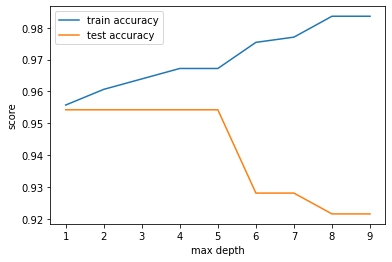

In [21]:
explore_max_depth(X_train, X_val, y_train, y_val)

### 3.4 

Interpret your results. Which max_depth do you think is the best? 

<font color='green'> Above we have plotted the accuracies for the decision tree for varying max_depth parameter and for both training and test sets. We can see that the accuracy with the training data increases with more depth in the decision tree, most probably due to overfitting. More interestingly, we can observe that for the test data, the accuracy of the decision tree does not change for max_depth values between 1 and 5. For values larger than 5, the accuracy even drops. Therefore, for this example it seems like choosing a max_depth of 1 would be the best choice, since it allows the model to achieve the highest performance with the smallest number of layers. </font> 

<a id="section4"></a>
## 4 Random Forest
---

In this section, you will explore another classifier: the Random Forest classifier. As mentioned during the lecture, the Random Forest classifier combines the output of multiple decision trees in order to generate the final output.

You should:

1. Train a Random Forest with the original 5 features selected in question 1.1. Return the names of the three most important features.  
2. Interpret your results.
3. Compare the results from the three models
4. Play with the Random Forest hyper-parameters. 
5. Interpret your results. 

### 4.1
Train a Random Forest with the original 5 features selected in question 1.1. Return the names of the three most important features.  

<font color='green'> This is again a pure implementation task, that requires the correct use of scikit-learn's RandomForestClassifier and the feature_importances_ function. </font> 

In [22]:
#### GRADED CELL ####
### 4.1
def build_random_forest(X_train, y_train, n_estimators=10):
    """
    Train a Random Forest classifier.
    1. Create a Random Forest classifier given max_depth
    2. Train the classifier 
    3. Extract the feature importance
    
    Parameters
    ----------
    X_train: DataFrame with features (training set) 
    y_train: np.array with target variable (training set)  
    n_estimators : the number of estimator in the random forest classifier
    
    
    Returns:
    -------
    clf: random forest classifier
    feature_importance: list of the names of the 3 most important of features
                        ordered by feature importance
    """
    # YOUR CODE HERE
    clf = RandomForestClassifier(n_estimators, random_state = 0) # create a Random Forest
    clf.fit(X_train, y_train) # train
    
    feature_importance = pd.Series(clf.feature_importances_, index=X_train.columns)
    feature_importance = list(feature_importance.sort_values(ascending=False).iloc[0:3].index)
    
    return clf, feature_importance

In [23]:
clf, feature_importance = build_random_forest(X_train, y_train) 

print("validation score of random forest:", clf.score(X_val, y_val))
print("most important features:", feature_importance)

validation score of random forest: 0.9411764705882353
most important features: ['Avgtimelast3SDnormed', 'Avg recent5wrong', 'Avgwrongpct-up']


### 4.2 

Interpret your results. How do the top three features from the RF differ from the top features from the DT? 


<font color='green'> From the feature_importance array, it can be observed that the two most important features are still x[1] and x[4] (Avgtimelast3SDnormed and Avg recent5wrong) like in the decision tree from the previous task. However, in the random forest also the other features gained a bit more in importance. This comes from the fact that random forest combines the results of multiple decision trees (in this example 10). </font> 

### 4.3 

Compare and discuss the results of three models (Regression, Decision Tree and Random Forest)

<font color='green'> From the results obtained with the different classifiers we could observe that the regression model showed the lowest performance in terms of accuracy (0.69). However, it should be noted that this result was obtained after applying the RobustScaler. Removing the RobustScaler or instead using a MinMaxScaler would yield in a accuracy similar to the other two approaches (0.95). This example shows how scaling can have a stong influence on the outcomes of the model. For this data set, it seems like the use of the RobustScaler reduces the information from our selected features and is therefore not appropriate. The decision tree on the other hand, yields a good performance in terms of accuracy (0.95) even for small values of max_depth. A great advantage of this approach is the interpretability of the results, that can be visualized and easily understood by human examination. Extending the decision tree to a random forest with multiple estimators slightly reduced accuracy (0.94), but on the other hand should increase robustness and avoid overfitting. It should be noted that all the results should be interpreted with the knowledge in mind that the data set is highly unbalanced and that a majority class classifier would yield a similar performance (0.95). It is therefore possible, that all three approaches may be biased to predicting the "N" class of OffTask. </font> 

### 4.4


As we have seen in the lecture and in the tutotial, there are multiple hyper-parameters that can be tuned in the Random Forest classifier (number of estimators, maximum depth, function to measure the quality of a split,  minimum number of samples required to be at a leaf node, minimum weighted fraction of the sum total of weights etc)

Pick only **one** hyper-parameter and explore the changes in accuracy as you vary the values. 

Plot the accuracy with the varying values for the hyper-parameter you selected (choose an appropriate range). 


<font color='green'> This is again a pure implementation task, in which you can decide whch hyper-parameter you want to vary. In this example we will illustrate the effect of the number of estimators. </font> 

In [28]:
#### GRADED CELL ####
### 4.4
def explore_hyperparameter(X_train, X_val, y_train, y_val):
    """
    Explore ONE chosen hyperparameter
    1. Get the accuracy score of Random Forest classifier 
        with varying values of ONE hyperparameter
    2. Plot the accuracy at different values 
    
    Parameters
    ----------
    X_train: DataFrame with features (training set) 
    X_val: DataFrame with features (validation set)
    y_train: np.array with target variable (training set) 
    y_val: np.array with target variable (validation set)
    
    
    Returns:
    -------
    None

    """
    # YOUR CODE HERE
    result_train = []
    result_test = []
    for i in range(1,100, 5):
        clf, _ = (build_random_forest(X_train, y_train, n_estimators=i)) # create model and train
        result_train.append(clf.score(X_train, y_train)) # calcuate accuracy for training setz
        result_test.append(clf.score(X_val, y_val)) # calcuate accuracy for test set
    
    # visualization
    plt.plot(range(1,100, 5), result_train, label="train accuracy")
    plt.plot(range(1,100, 5), result_test, label="test accuracy")
    plt.xlabel("num of estimator")
    plt.ylabel("score")
    plt.legend()
    plt.xticks(range(1,100,10))
    plt.show()

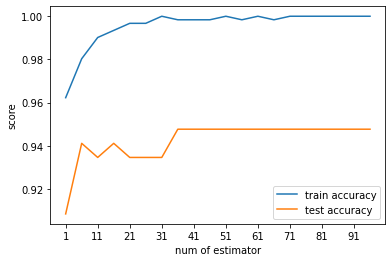

In [29]:
explore_hyperparameter(X_train, X_val, y_train, y_val)

### 4.5 

Interpret your results. Justify your choice of hyper-parameter. What effect does the hyper-parameter selected have on the model? In this case, which is the optimal value? Why? 

<font color='green'> From the above plot we can observe that the accuracy of the random forest increases with the number of estimators. The increase is steeper in the beginning and then settles at around 41 estimators. However, whether this is the optimal value to choose depends also on the computational power available and the accuracy desired. If efficiency is a factor, one could for instance, consider to choose 6 estimators which results in a accuracy of 0.94 with reasonable computational effort. </font> 


## 5 Creative extension
---

In this last part, we will ask you to be creative and extend the set of five features you are using. 

1. Conduct feature engineering to create at least 5 new features that cannot be created using just the original data set. Add the new features to the original data set. 
2. Train a Random Forest classifier with the extended set of features. 
3. Interpret your results. 

The goal of this last part is to build a better behavior detector (classifier), using the features you selected in the part part as well as new features you will create based on the new data we are providing now to youfor this question. 

In the first part, you have used the dataset stored in <code>ca1‐dataset.csv</code> in a CSV format, this data set has already been aggregated by `UniqueID`. Now, you will need to play also with the dataset stored in <code>ca2‐dataset.csv</code>, in a CSV format as well.

These two datasets represent the same data set, but at two different grain‐sizes. Specifically, the new data (<code>ca2‐dataset.csv</code>) represents individual raw student actions within educational software, while the previous data set (<code>ca1‐dataset.csv</code>) is at the grain size of all the actions that occurred during 20 second field observations by students. Note that the individual raw student actions are labeled with the same UniqueID labels as the observations are (each `UniqueID` corresponds to a single field observation). In this question, you must conduct feature engineering to improve the features in the original data set, using the data in the new data set. You must create at least **five** new features that cannot be created using just the original data set, and add the new features to the set of features you have selected in the first part of the homework. 

#### About the individual raw student actions dataset

Our target is to identify that one specific behavioral for students. The detailed description of features are given as below. The features are related to the information how the student interacting with the system for individual actions. 

The description of the features for the individual raw actions in  <code>ca2‐dataset.csv</code> is provided below. 


| Name                   | Description                         |
| ---------------------- | ------------------------------------------------------------ |
| right| 1 if the action is right, 0 otherwise|
|	bug| 1 if there is a bug, 0 otherwise|
|	pknow-1| Knowledge estimation before the action|
|	Pknow-2| Knowledge estimation after the action |
|	pchange| 1 if the knowledge estimation changes, 0 otherwise|
|	time| Time spent in seconds|
|	timeSDnormed| For last action, (time taken – avg(cell)  / SD(cell) (SD is a function)|
|	timelast3SDnormed| For last 3 action, (time taken – avg(cell)  / SD(cell) (SD is a function)|
|	timelast5SDnormed| For last 5 action, (time taken – avg(cell)  / SD(cell) (SD is a function)|
|	notright| 1 if the action is not right, 0 otherwise|
|	howmanywrong-up| How many of the actions are wrong up to the current action|
|	wrongpct-up| (total number of wrong actions)/( number of steps where skill encountered so far)|
|	timeperact-up| Total time so far on all actions involving this production, for all problems|
|	Prev3Count-up| Count of, for each of last 3 actions, how many involved the same interface widget|
|	Prev5Count-up| Count of, for each of last 5 actions, how many involved the same interface widget|
|	 recent5wrong| Of the last 5 actions, how many were wrong|
|	manywrong-up | Total number of actions where this production was wrong up to the current action|
|	Unique-id| ID of the aggregated observation (one observation aggregates interactions within a 20 second timeframe)|


**Please note that pknow-1 and pknow-2 only exist in second data set**

**The data set is available in the folder data**. 

In [ ]:
# Read the second dataset
df_raw = pd.read_csv("./data/ca2-dataset.csv")

# Let's see how the dataframe looks like
print("length of the dataframe:", len(df))
print("first rows of the dataframe:\n")
df_raw.head()

You should note that the features stated in <code>ca1‐dataset.csv</code> were obtained by conducting feature engineering in <code>ca2‐dataset.csv</code>. To make it clearer, we provide you with an example. Let's consider the 55th row in the original dataset:

In [ ]:
df.loc[52]

This row has been obtained by computing the average of each column for the rows between 55 and 58 in the dataset <code>ca2‐dataset.csv</code>. Specifically, in the second dataset, **we group by the column Unique-id** to group all the rows recorded in the same 20 seconds of interactions. Then, we select the group with Unique-id equal to the one of the row above in the original dataset. 



In [ ]:
groups = df_raw.groupby(by='Unique-id', as_index=False).mean()
groups[groups['Unique-id'] == df.loc[52]['Unique-id']]

It can be observed that the Avgright in <code>df.iloc[52]</code> is the same we obtained by group data in the second dataset and picking the corresponding `Unique-id`. The same observation applies to the other columns. 

### 5.1 
Create at least 5 new features from df_raw 

<font color='green'> In this subtask a lot of different solutions are possible. Below we present five examples of possible new features. </font> 

In [ ]:
#### GRADED CELL ####
### 5.1
def extend_features(df_five, df_raw, df_five_id = None):
    """
    Create at least 5 new features from df_raw 
    
    Parameters
    ----------
    df_five : DataFrame with processed data (5 features)
    df_raw:   DataFrame with raw data
    df_five_id: (optional) DataFrame with Unique-ids from df_five 
    
    Returns:
    -------
    df_ext_five: DataFrame with extended features 
        (the five you selected in the first part + 
        the five you create here + the target off-task label)

    """
    # YOUR CODE HERE
    
    
    # Feature 1: Average knowledge before action 
    feat_avgpknow1 = df_raw.groupby("Unique-id")["pknow-1"].mean()
    
    # Feature 2: Average knowledge after action 
    feat_avgpknow2 = df_raw.groupby("Unique-id")["Pknow-2"].mean()
    
    # Feature 3: Average knowledge gain  
    df_raw['Avgknowgain'] = df_raw['Pknow-2'] - df_raw['pknow-1']
    feat_avgknowgain = df_raw.groupby("Unique-id")["Avgknowgain"].mean()

    # Feature 4: Percentage of total correct answers
    feat_perright = df_raw.groupby("Unique-id")["right"].sum() / df_raw.groupby("Unique-id")["right"].count()

    # Feature 5: Total time spent by student
    feat_totaltime = df_raw.groupby("Unique-id")["timeperact-up"].max()
    
    
    df_ext_five = df_five
    df_ext_five["avgpknow1"] = feat_avgpknow1.values
    df_ext_five["avgpknow2"] = feat_avgpknow2.values
    df_ext_five["avgknowgain"] = feat_avgknowgain.values
    df_ext_five["perright"] = feat_perright.values
    df_ext_five["totaltime"] = feat_totaltime.values    
    
    return df_ext_five

In [ ]:
df_ext_five = extend_features(df_five,  df_raw, df_five_id)
X_train, X_val, y_train, y_val = split_data(df_ext_five)

### 5.2

Use the previously created `build_random_forest` function to train the models with the extended DataFrame. Print out the accuracy. 

In [ ]:
# YOUR CODE HERE
clf, feature_importance = build_random_forest(X_train, y_train) # build a classifier
print("validation score of random forest:", clf.score(X_val, y_val))
print("feature importance:", feature_importance)


### 5.3

Interpret and compare your results. Did the new features improve the score? Write down your intuition about the possible reasons.

In [ ]:
pd.DataFrame({'names': X_train.columns,'importance': clf.feature_importances_}).sort_values('importance', ascending=False)

<font color='green'> It can be seen that adding the new features improved the accuracy of the random forest classifier from previously 0.94 to now 0.95. The influence of the new features can also be observed from the feature importance vector: three of them, `totaltime`, `avgpknow2` and `avgpknow1` are know among the four most impotant predictors in the random forest model. While the five presented features only represent examples, it is clear that the creation of new features can always be improved. [Feature engineering](https://en.wikipedia.org/wiki/Feature_engineering) is an essential part in machine learning projects and often, domain knowledge can help to create more meaningful features. </font> 